In [152]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as mp
import time
import skimage as ski

In [153]:
nanos_to_seconds = 1/1e6

dete_temp = np.genfromtxt('data/detectorTemp.txt', delimiter=',') #import delimited data
dete_temp = dete_temp[1:] #trim off nans created from lable line
dete_temp[:,0] = dete_temp[:,0]*nanos_to_seconds #convert to seconds right away

dist_dopp = np.genfromtxt('data/distanceAndDoppler.txt', delimiter=',') #import delimited data
dist_dopp = dist_dopp[1:] #trim off nans created from lable line
dist_dopp[:,0] = dist_dopp[:,0]*nanos_to_seconds #convert to seconds right away

inst_tele = np.genfromtxt('data/instrumentTelemetry.txt', delimiter=',') #import delimited data
inst_tele = inst_tele[1:] #trim off nans created from lable line
inst_tele[:,0] = inst_tele[:,0]*nanos_to_seconds #convert to seconds right away

inte_time = np.genfromtxt('data/integrationTime.txt', delimiter=',') #import delimited data
inte_time = inte_time[1:] #trim off nans created from lable line
inte_time[:,0] = inte_time[:,0]*nanos_to_seconds #convert to seconds right away

# plans = np.genfromtxt('lasp_dsse_hw/data/plans.txt', delimiter=',') #import delimited data
# plans = plan[1:] #trim off nans created from lable line

refe_spec = np.genfromtxt('data/referenceSpectrum.txt', delimiter=',') #import delimited data
refe_spec = refe_spec[1:] #trim off nans created from lable line


4201


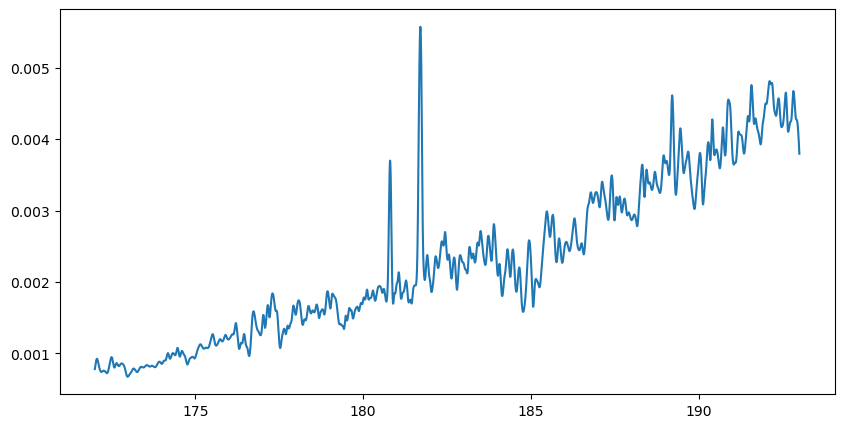

In [154]:
mp.figure(figsize=(10,5))
mp.plot(refe_spec[:,0],refe_spec[:,1]) #glance at the refernce spectrum to check sanity
print(len(refe_spec[:,0]))

down time seconds: 4422.25
dark time seconds: 4413.439999938011
up time seconds: 4404.120000004768
down samples: 2527
dark samples: 4414
up samples: 2517


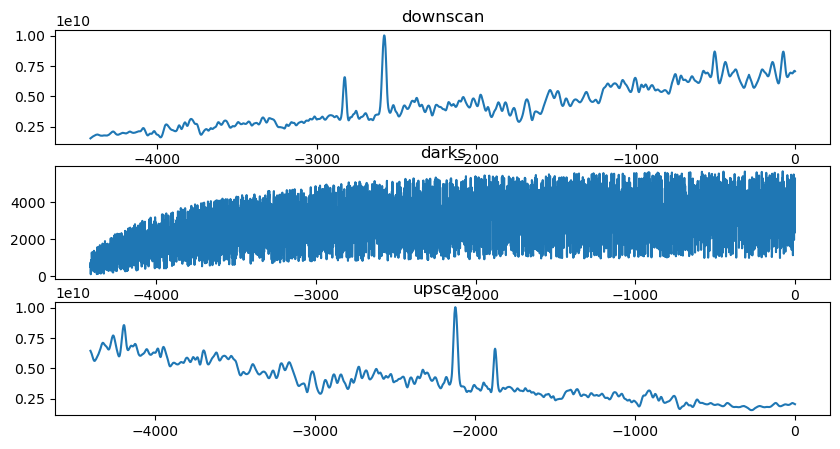

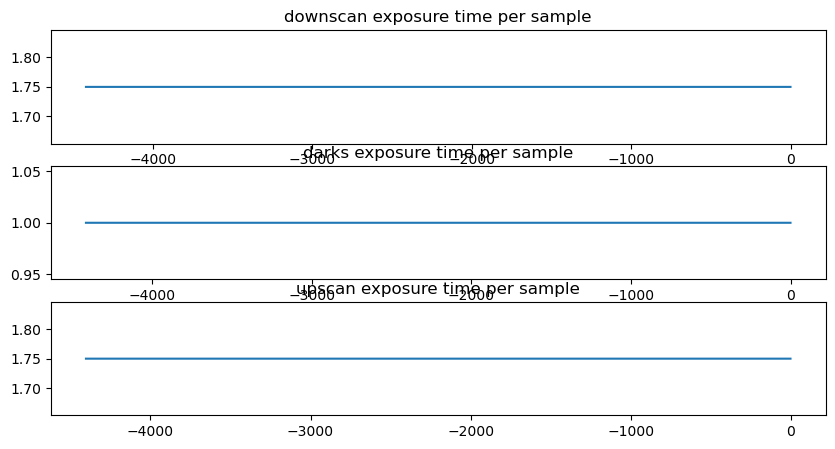

In [175]:
#let's find out what's inside the telemetry
#planName, startTime, endTime #all in µs
#DownScan, 9.434134508500002E14, 9.434178731000002E14
#Dark, 9.434192873600002E14, 9.434237008000002E14
#UpScan, 9.434251237500002E14, 9.434295278700002E14
# we are interested in the "plan" which starts at 9.434134508500002E14
down_start_time = 9.434134508500002e8
down_end_time = 9.434178731000002e8
print("down time seconds: "+str((down_end_time-down_start_time)))
dark_start_time = 9.434192873600002e8
dark_end_time = 9.434237008000002e8
print("dark time seconds: "+str((dark_end_time-dark_start_time)))
up_start_time = 9.434251237500002e8
up_end_time = 9.434295278700002e8
print("up time seconds: "+str((up_end_time-up_start_time)))

data_end_time = 9.434295267500002E14 #instrument telemetry ends at 9.434295267500002E14, which isn't the end of the upscan planned time, so that's a thing to figure out.

down_start = np.where (inst_tele[:,0]>=down_start_time)[0][0]
down_end = np.where (inst_tele[:,0]>=down_end_time)[0][0]
print("down samples: "+str(down_end-down_start))
dark_start = np.where (inst_tele[:,0]>=dark_start_time)[0][0]
dark_end = np.where (inst_tele[:,0]>=dark_end_time)[0][0]
print("dark samples: "+str(dark_end-dark_start))
up_start = np.where (inst_tele[:,0]>=up_start_time)[0][0]
up_end = len(inst_tele[:,0]) #np.where (inst_tele[:,0]==up_end_time)[0][0] #this breaks, looks like the data ends before the plan does.
print("up samples: "+str(up_end-up_start))

down = inst_tele[down_start:down_end,:]
dark = inst_tele[dark_start:dark_end,:]
up = inst_tele[up_start:up_end,:]

#we got lucky that "==" worked, though we could have done ">" and taken the first element of the output array.

# mp.figure(figsize=(9,3))
# mp.title('microsecondsSinceGpsEpoch per data point')
# mp.plot(inst_tele[down_start:up_end-1,0]-down_start_time,np.diff(inst_tele[down_start:up_end,0]))
# mp.show()

# mp.figure(2,figsize=(9,3))
fig, axs = mp.subplots(3,1, figsize=(10,5))
axs[0].plot(down[:,0]-down[-1,0], down[:,2])
axs[0].title.set_text('downscan')
axs[1].plot(dark[:,0]-dark[-1,0], dark[:,2])
axs[1].title.set_text('darks')
axs[2].plot(up[:,0]-up[-1,0], up[:,2])
axs[2].title.set_text('upscan')
# fig.show()

# mp.figure(2,figsize=(9,3))
fig, axs = mp.subplots(3,1, figsize=(10,5))
axs[0].plot(down[:-1,0]-down[-1,0], np.diff(down[:,0]))
axs[0].title.set_text('downscan exposure time per sample')
axs[1].plot(dark[:-1,0]-dark[-1,0], np.diff(dark[:,0]))
axs[1].title.set_text('darks exposure time per sample')
axs[2].plot(up[:-1,0]-up[-1,0], np.diff(up[:,0]))
axs[2].title.set_text('upscan exposure time per sample')

# fig.show()

down time seconds: 4422.25
dark time seconds: 4413.439999938011
up time seconds: 4404.120000004768
down samples: 4422
dark samples: 4414
up samples: 4405
rough estimate of sunlight temp delta: 2.9059364733850934


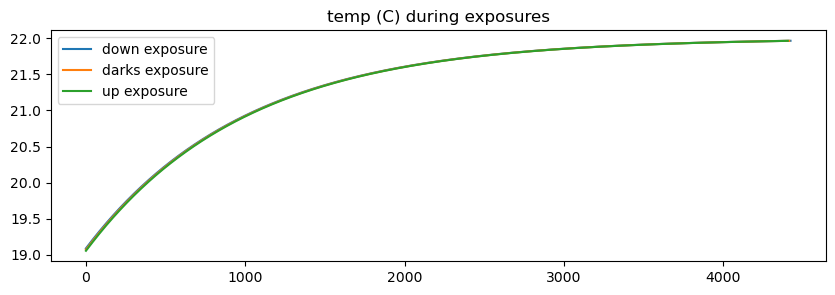

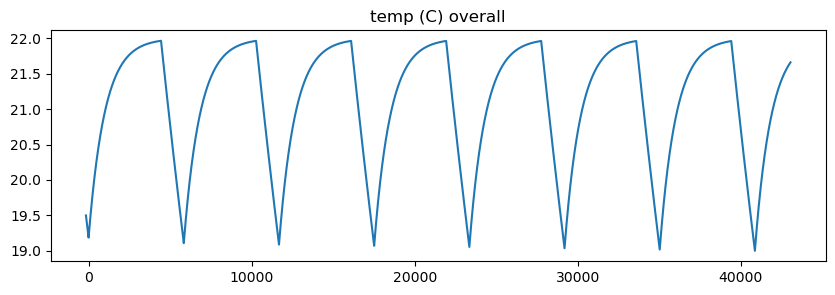

In [156]:
down_start_time = 9.434134508500002e8
down_end_time = 9.434178731000002e8
print("down time seconds: "+str((down_end_time-down_start_time)))
dark_start_time = 9.434192873600002e8
dark_end_time = 9.434237008000002e8
print("dark time seconds: "+str((dark_end_time-dark_start_time)))
up_start_time = 9.434251237500002e8
up_end_time = 9.434295278700002e8
print("up time seconds: "+str((up_end_time-up_start_time)))

down_start_temp = np.where (dete_temp[:,0]>=down_start_time)[0][0]
down_end_temp = np.where (dete_temp[:,0]>=down_end_time)[0][0]
print("down samples: "+str(down_end_temp-down_start_temp))
dark_start_temp = np.where (dete_temp[:,0]>=dark_start_time)[0][0]
dark_end_temp = np.where (dete_temp[:,0]>=dark_end_time)[0][0]
print("dark samples: "+str(dark_end_temp-dark_start_temp))
up_start_temp = np.where (dete_temp[:,0]>=up_start_time)[0][0]
up_end_temp = np.where (dete_temp[:,0]>=up_end_time)[0][0] #this breaks, looks like the data ends before the plan does.
print("up samples: "+str(up_end_temp-up_start_temp))

print('rough estimate of sunlight temp delta: ' +str(dete_temp[up_end_temp,1]-dete_temp[up_start_temp,1]))

mp.figure(figsize=(10,3))
mp.title('temp (C) during exposures')
mp.plot(dete_temp[down_start_temp:down_end_temp,0]-dete_temp[down_start_temp,0],dete_temp[down_start_temp:down_end_temp,1])
mp.plot(dete_temp[dark_start_temp:dark_end_temp,0]-dete_temp[dark_start_temp,0],dete_temp[dark_start_temp:dark_end_temp,1])
mp.plot(dete_temp[up_start_temp:up_end_temp,0]-dete_temp[up_start_temp,0],dete_temp[up_start_temp:up_end_temp,1])
mp.legend(['down exposure','darks exposure','up exposure'])
# mp.plot(dete_temp[162:4604,1])

ax = mp.figure(figsize=(10,3))
mp.title('temp (C) overall')
mp.plot(dete_temp[:,0]-dete_temp[162,0],dete_temp[:,1])


/var/folders/mp/k4kwc0t11kx7jzwyr3fqtvsh0000gn/T/ipykernel_2483/1992773793.py:8: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x+c)+d


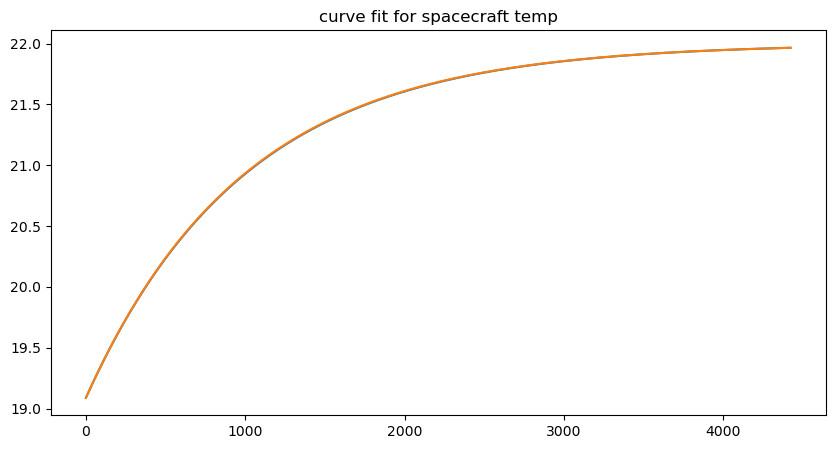

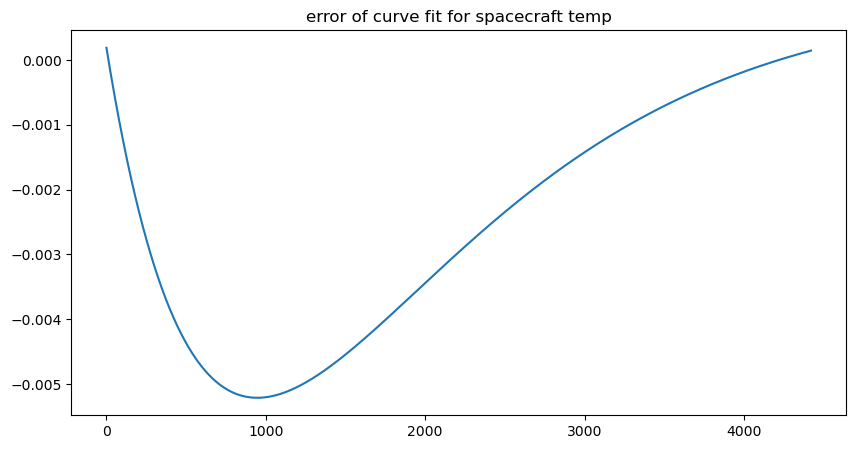

In [157]:
#lets try axtracting a curve from temp, to see if we'll be able to use the method for the noisier darks

sample_pass = dete_temp[down_start_temp:down_end_temp,:]


#we need a function to fit the shape of a-exp(b/(x-c))
def heat_curve(x, a, b, c, d):
    return a*np.exp(b*x+c)+d

def minimization(args):
    a,b,c,d = args[0],args[1],args[2],args[3]
    array1 = sample_pass[:,1]
    array2 = heat_curve(sample_pass[:,0]-sample_pass[0,0],a,b,c,d)
    dist = array1-array2
    return sum(dist)

# ans = sp.optimize.minimize(minimization,np.asarray([30,sample_pass[0,0]+1e9/1e9,1/1e9]),method='COBYLA',tol=1e-3)
ans = sp.optimize.minimize(minimization,np.asarray([-1, -1/9.94e2, 9.49094e5+15.1685, 21.999]),method='SLSQP', options={'ftol':0.01,'eps':0.0001})
mp.figure(figsize=(10,5))
mp.title('curve fit for spacecraft temp')
mp.plot(sample_pass[:,0]-sample_pass[0,0], sample_pass[:,1])
mp.plot(sample_pass[:,0]-sample_pass[0,0], heat_curve(sample_pass[:,0],-1, -1/9.94e2, 9.49094e5+15.1685, 21.999))
# #ok, so I'm able to improve the optimization by hand, by looking at the graph, so I'm going to say that the optimize function isn't doing much here.
# 
# print(ans)

mp.figure(figsize=(10,5))
mp.title('error of curve fit for spacecraft temp')
mp.plot(sample_pass[:,0]-sample_pass[0,0], sample_pass[:,1]-heat_curve(sample_pass[:,0],-1, -1/9.94e2, 9.49094e5+15.1685, 21.999))

In [158]:
# I want some filters, so I'm copying these for a former project of mine, these are exclusively my work, so they fit within the allowed resources. 
import math as m
import numpy as np
import typing
import xarray as xr


def fourier_filter(
        signal: typing.Union[np.ndarray, xr.DataArray],
        frequency: float,
        cutoff_frequency_low: float = 0,
        cutoff_frequency_high: float = 0,
        time_axis: int = 0,
        low_pass: bool = False,
        high_pass: bool = False,
        band_pass: bool = False,
        band_block: bool = False) -> typing.Union[np.ndarray, xr.DataArray]:
    """Filter a dataset by frequency. This function allows for low_pass,
    high_pass, band_pass, or band_block filtering of the data's freqency
    representation.

    Parameters
    ----------
    signal : ndarray, :class:`xarray.DataArray`
        n-dimensional dataset

    frequency : :class:`float`
        sample frequency of dataset

    cutoff_frequency_low : float, optional
        low frequency for cutting fourier transform, used by low_pass, band_pass, band_block. Defaults to 0.

    cutoff_frequency_high : float, optional
        high frequency for cutting fourier transform, used by low_pass, band_pass, band_block. Defaults to 0.

    time_axis : int, optional
        the time axis of the data set. Defaults to 0.

    low_pass : bool, optional
        runs a low_pass filter on the data if set to True. Defaults to False.

    high_pass : bool, optional
        runs a high_pass filter on the data if set to True. Defaults to False.

    band_pass : bool, optional
        runs a band_pass filter on the data if set to True. Defaults to False.

    band_block : bool, optional
        runs a band_block filter on the data if set to True. Defaults to False.

    Returns
    -------
    return_signal : ndarray, :class:`xarray.DataArray`
        signal with specified filters applied

    """
    resolution = frequency / len(signal)
    signal = np.swapaxes(signal, time_axis, 0)
    res_fft = np.fft.fft(signal, axis=0)
    cfl_index = m.floor(cutoff_frequency_low / resolution)
    cfln_index = 1 - cfl_index
    cfh_index = m.ceil(cutoff_frequency_high / resolution)
    cfhn_index = 1 - cfh_index
    if low_pass:
        if cfl_index > 1:
            res_fft[cfl_index:cfln_index] = np.zeros(
                res_fft[cfl_index:cfln_index].shape)
        else:
            res_fft[cfl_index:] = np.zeros(res_fft[cfl_index:].shape)
    if high_pass:
        res_fft[:cfh_index] = np.zeros(res_fft[:cfh_index].shape)
        if cfh_index > 1:
            res_fft[cfhn_index:] = np.zeros(res_fft[cfhn_index:].shape)
    if band_pass:
        res_fft[:cfl_index] = np.zeros(res_fft[:cfl_index].shape)
        if cfh_index > 1:
            res_fft[cfh_index:cfhn_index] = np.zeros(
                res_fft[cfh_index:cfhn_index].shape)
        else:
            res_fft[cfh_index:] = np.zeros(res_fft[cfh_index:].shape)
        if cfl_index > 1:
            res_fft[cfln_index:] = np.zeros(res_fft[cfln_index:].shape)
    if band_block:
        res_fft[cfl_index:cfh_index] = np.zeros(
            res_fft[cfl_index:cfh_index].shape)
        if cfl_index > 1 and cfh_index > 1:
            res_fft[cfhn_index:cfln_index] = np.zeros(
                res_fft[cfhn_index:cfln_index].shape)
        elif cfh_index > 1:
            res_fft[cfhn_index:] = np.zeros(res_fft[cfhn_index:].shape)
    result = np.fft.ifft(res_fft, axis=0)
    result = np.real(result)
    result = np.swapaxes(result, time_axis, 0)
    if type(signal) == xr.DataArray:
        xr_result = signal.copy()
        xr_result.data = result
        result = xr_result
    return result


def fourier_low_pass(
        signal: typing.Union[np.ndarray, xr.DataArray],
        frequency: float,
        cutoff_frequency_low: float,
        time_axis: int = 0) -> typing.Union[np.ndarray, xr.DataArray]:
    """Filter a dataset by frequency. This function allowes for low_pass
    filtering of the data's freqency representation.

    Parameters
    ----------
    signal : ndarray, :class:`xarray.DataArray`
        n-dimensional dataset

    frequency : :class:`float`
        sample frequency of dataset

    cutoff_frequency_low : :class:`float`
        low frequency for cutting fourier transform

    time_axis : int, optional
        the time axis of the data set. Defaults to 0.

    Returns
    -------
    return_signal : ndarray, :class:`xarray.DataArray`
        signal with specified filters applied
    """
    return fourier_filter(signal,
                          frequency,
                          cutoff_frequency_low=cutoff_frequency_low,
                          time_axis=time_axis,
                          low_pass=True)


def fourier_high_pass(
        signal: typing.Union[np.ndarray, xr.DataArray],
        frequency: float,
        cutoff_frequency_high: float,
        time_axis: int = 0) -> typing.Union[np.ndarray, xr.DataArray]:
    """Filter a dataset by frequency. This function allowes for high_pass
    filtering of the data's freqency representation.

    Parameters
    ----------
    signal : ndarray, :class:`xarray.DataArray`
        n-dimensional dataset

    frequency : :class:`float`
        sample frequency of dataset

    cutoff_frequency_high : :class:`float`
        high frequency for cutting fourier transform

    time_axis : int, optional
        the time axis of the data set. Defaults to 0.

    Returns
    -------
    return_signal : ndarray, :class:`xarray.DataArray`
        signal with specified filters applied
    """
    return fourier_filter(signal,
                          frequency,
                          cutoff_frequency_high=cutoff_frequency_high,
                          time_axis=time_axis,
                          high_pass=True)


def fourier_band_pass(
        signal: typing.Union[np.ndarray, xr.DataArray],
        frequency: float,
        cutoff_frequency_low: float,
        cutoff_frequency_high: float,
        time_axis: int = 0) -> typing.Union[np.ndarray, xr.DataArray]:
    """Filter a dataset by frequency. This function allowes for band_pass
    filtering of the data's freqency representation.

    Parameters
    ----------
    signal : ndarray, :class:`xarray.DataArray`
        n-dimensional dataset

    frequency : :class:`float`
        sample frequency of dataset

    cutoff_frequency_low : :class:`float`
        low frequency for cutting fourier transform

    cutoff_frequency_high : :class:`float`
        high frequency for cutting fourier transform

    time_axis : int, optional
        the time axis of the data set. Defaults to 0.

    Returns
    -------
    return_signal : ndarray, :class:`xarray.DataArray`
        signal with specified filters applied
    """
    return fourier_filter(signal,
                          frequency,
                          cutoff_frequency_low=cutoff_frequency_low,
                          cutoff_frequency_high=cutoff_frequency_high,
                          time_axis=time_axis,
                          band_pass=True)


def fourier_band_block(
        signal: typing.Union[np.ndarray, xr.DataArray],
        frequency: float,
        cutoff_frequency_low: float,
        cutoff_frequency_high: float,
        time_axis: int = 0) -> typing.Union[np.ndarray, xr.DataArray]:
    """Filter a dataset by frequency. This function allowes for band_block
    filtering of the data's freqency representation.

    Parameters
    ----------
    signal : ndarray, :class:`xarray.DataArray`
        n-dimensional dataset

    frequency : :class:`float`
        sample frequency of dataset

    cutoff_frequency_low : :class:`float`
        low frequency for cutting fourier transform

    cutoff_frequency_high : :class:`float`
        high frequency for cutting fourier transform

    time_axis : int, optional
        the time axis of the data set. Defaults to 0.

    Returns
    -------
    return_signal : ndarray, :class:`xarray.DataArray`
        signal with specified filters applied
    """
    return fourier_filter(signal,
                          frequency,
                          cutoff_frequency_low=cutoff_frequency_low,
                          cutoff_frequency_high=cutoff_frequency_high,
                          time_axis=time_axis,
                          band_block=True)

[ 17.85637873 827.45267141]


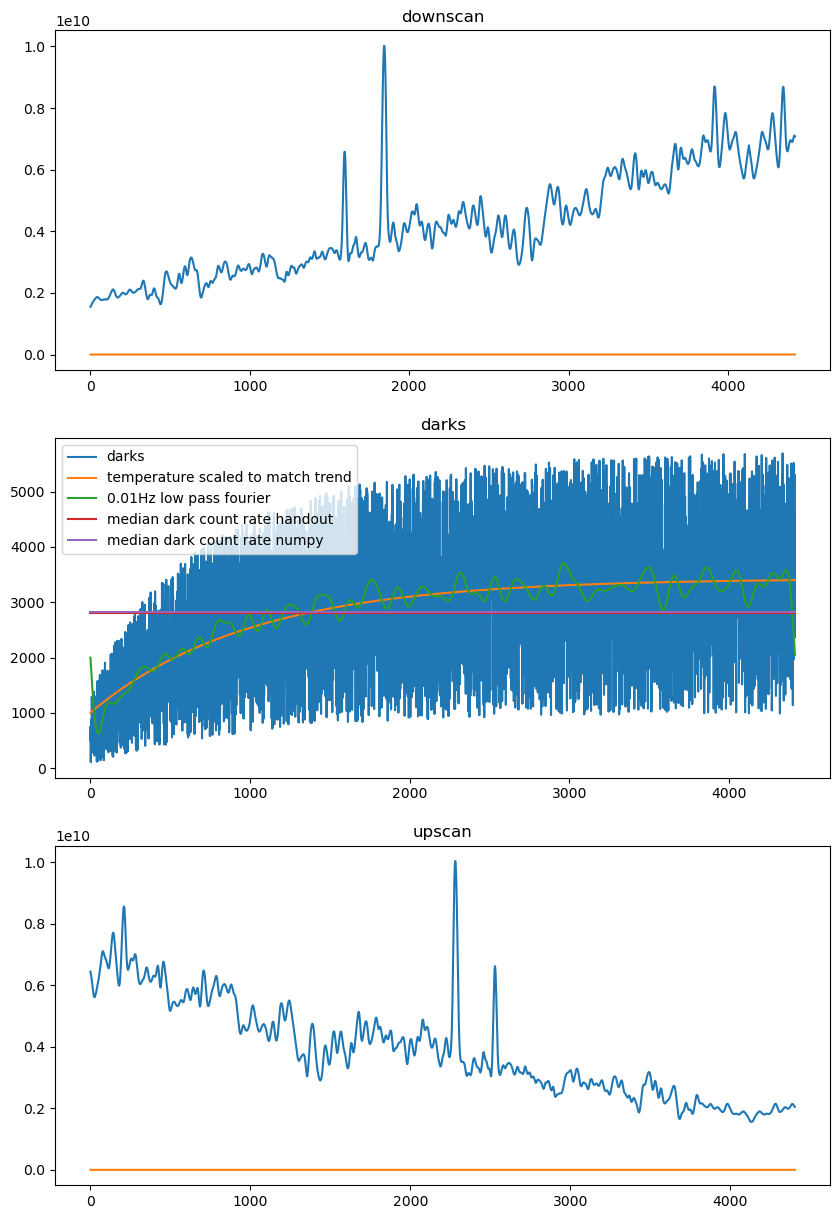

In [159]:
#Temp correction


fig, axs = mp.subplots(3,1, figsize=(10,15))


axs[1].title.set_text('darks')
axs[1].plot(inst_tele[dark_start:dark_end,0]-dark_start_time, inst_tele[dark_start:dark_end,2])
#darks my way
def minimization(args):
    a,b = args[0],args[1]
    array1 = inst_tele[dark_start:dark_end,2]
    array2 = (dete_temp[dark_start_temp:dark_end_temp,1]-a)*b
    dist = array1-array2
    return sum(dist**2)
temp_scale_fit = sp.optimize.minimize(minimization,np.asarray([-18,800]),method='SLSQP')
print(temp_scale_fit.x)
axs[1].plot(dete_temp[dark_start_temp:dark_end_temp,0]-dete_temp[dark_start_temp,0],(dete_temp[dark_start_temp:dark_end_temp,1]-temp_scale_fit.x[0])*temp_scale_fit.x[1])
#show the trend using a low pass filter
axs[1].plot(inst_tele[dark_start:dark_end,0]-inst_tele[dark_start,0],fourier_low_pass(inst_tele[dark_start:dark_end,2],1,1/100))
#darks the handout way
dark_integrationTime = 1.0
dark_counts = inst_tele[dark_start:dark_end,2] #number of draculas
detectorTemp = dete_temp[dark_start_temp:dark_end_temp,1]
tempCorrFactor = 0.0061628 # [counts/degC]
dark_count_rate = dark_counts / dark_integrationTime
dark_count_rate_corr = dark_count_rate * (1.0 + tempCorrFactor * (20.0 - detectorTemp))
median_dark_count_rate1 = np.median(dark_count_rate_corr)
axs[1].plot([0,inst_tele[dark_end,0]-inst_tele[dark_start,0]], [median_dark_count_rate1, median_dark_count_rate1])
#ez mode median dark count rate using np.median()
median_dark_count_rate2 = np.median(inst_tele[dark_start:dark_end,2])
axs[1].plot([0,inst_tele[dark_end,0]-inst_tele[dark_start,0]], [median_dark_count_rate2, median_dark_count_rate2])

axs[1].legend(['darks', 'temperature scaled to match trend', '0.01Hz low pass fourier', 'median dark count rate handout','median dark count rate numpy'])

axs[2].title.set_text('upscan')
axs[2].plot(inst_tele[up_start:up_end,0]-up_start_time, inst_tele[up_start:up_end,2])
axs[2].plot(dete_temp[up_start_temp:up_end_temp,0]-dete_temp[up_start_temp,0],(dete_temp[up_start_temp:up_end_temp,1]-temp_scale_fit.x[0])*temp_scale_fit.x[1])

axs[0].title.set_text('downscan')
axs[0].plot(inst_tele[down_start:down_end,0]-down_start_time, inst_tele[down_start:down_end,2])
axs[0].plot(dete_temp[down_start_temp:down_end_temp,0]-dete_temp[down_start_temp,0],(dete_temp[down_start_temp:down_end_temp,1]-temp_scale_fit.x[0])*temp_scale_fit.x[1])

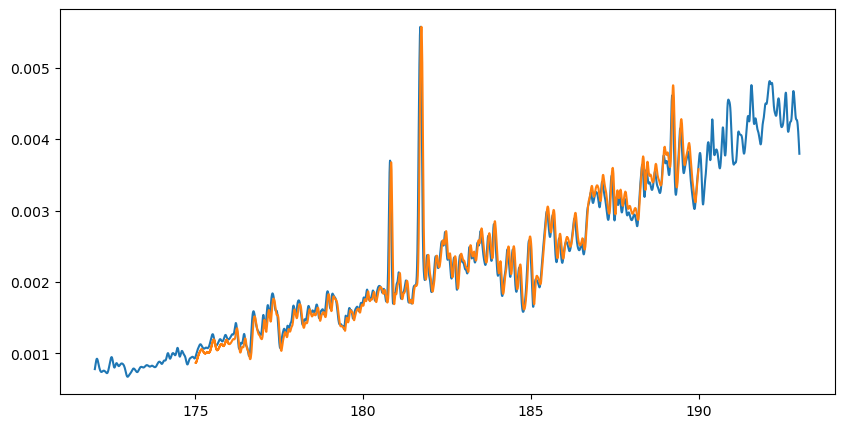

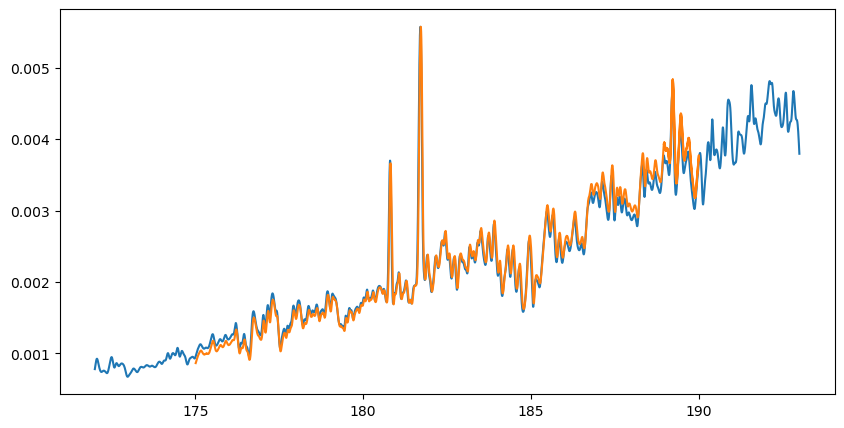

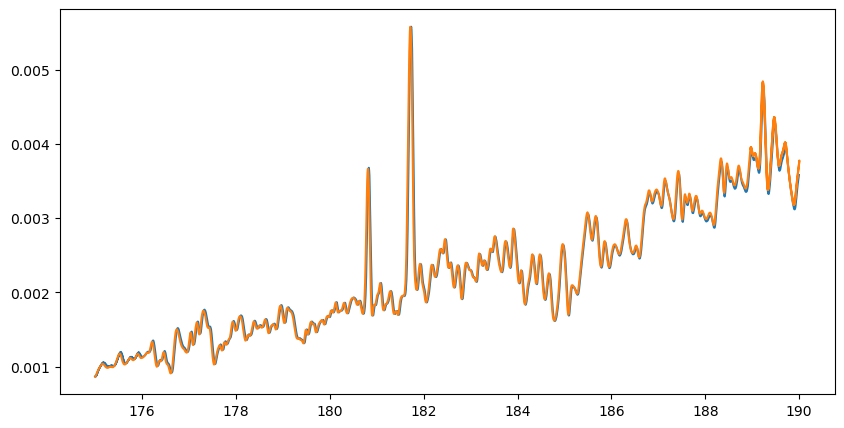

In [165]:
#wavelengths
offset = 239532.38
stepSize = 2.4237772022101214E-6  # [rad/step]
d = 277.77777777777777  # [nm]
phiGInRads = 0.08503244115716374  # [rad]
#gratingPosition comes from inst_tele[:,1]
gratingPosition = inst_tele[:,1]
ang1 = (offset - gratingPosition) * stepSize  # [rad]
wavelength = 2 * d * np.sin(ang1) * np.cos(phiGInRads / 2.0)  # [nm]
conda
mp.figure(figsize=(10,5))
mp.plot(refe_spec[:,0],refe_spec[:,1])
mp.plot(wavelength[up_start:up_end], (inst_tele[up_start:up_end,2])*np.max(refe_spec[:,1])/np.max(inst_tele[up_start:up_end,2]))
mp.figure(figsize=(10,5))
mp.plot(refe_spec[:,0],refe_spec[:,1])
mp.plot(wavelength[down_start:down_end], (inst_tele[down_start:down_end,2])*np.max(refe_spec[:,1])/np.max(inst_tele[down_start:down_end,2]))

mp.figure(figsize=(10,5))
mp.plot(wavelength[up_start:up_end], (inst_tele[up_start:up_end,2])*np.max(refe_spec[:,1])/np.max(inst_tele[up_start:up_end,2]))
mp.plot(wavelength[down_start:down_end], (inst_tele[down_start:down_end,2])*np.max(refe_spec[:,1])/np.max(inst_tele[down_start:down_end,2]))

# maybe use scikit-image.transform.resize to get the heat curve in the same length as the data bins
up_dark_counts = ski.transform.resize((dete_temp[dark_start_temp:dark_end_temp,1]-temp_scale_fit.x[0])*temp_scale_fit.x[1],)

In [169]:
(dete_temp[dark_start_temp:dark_end_temp,1]-temp_scale_fit.x[0])*temp_scale_fit.x[1]


array([1005.54477517, 1007.96788088, 1010.38856349, ..., 3399.2915139 ,
       3399.32087287, 3399.35020249])

In [ ]:
down_start = np.where (inst_tele[:,0]>=down_start_time)[0][0]

In [ ]:
down_start

In [ ]:
down_end = np.where (inst_tele[:,0]>=down_end_time)[0][0]

In [ ]:
down_end